# Olist : clusterisation et maintenance

In [1]:
#librairies import

import pandas as pd
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import davies_bouldin_score

In [2]:
data = pd.read_csv('data/olist_customers_whole.csv')

In [3]:
data.head()

,customer_unique_id,first_purchase,last_purchase,total_orders,total_spent,average_review_score,all_comments,total_price_items,total_freight_value,product_categories,seller_cities,order_statuses
0,8d50f5eadf50201ccdcedfb9e2ac8455,2017-05-15 23:30:03,2018-08-20 19:14:26,17,927.63,NaN,NaN,729.62,172.42,"construcao_ferramentas_ferramentas, esporte_la...","campinas, curitiba, joinville, londrina, sao j...","delivered, shipped, unavailable"
1,3e43e6105506432c953e165fb2acf44c,2017-09-18 18:53:15,2018-02-27 18:36:39,9,1963.58,NaN,NaN,1000.85,171.82,"cama_mesa_banho, casa_construcao, informatica_...","ibitinga, jaguariuna, porto alegre, rio de jan...",delivered
2,6469f99c1f9dfae7733b25662e7f1782,2017-09-19 01:02:44,2018-06-28 00:43:34,7,973.09,NaN,NaN,664.20,94.63,cama_mesa_banho,"ibitinga, piracicaba, sao paulo",delivered
3,ca77025e7201e3b30c44b472ff346268,2017-10-09 12:34:39,2018-06-01 11:38:29,7,2126.44,NaN,NaN,806.61,316.11,"cama_mesa_banho, cool_stuff, moveis_decoracao,...","ibitinga, pedreira, sao paulo",delivered
4,1b6c7548a2a1f9037c1fd3ddfed95f33,2017-11-13 16:44:41,2018-02-14 13:22:12,7,1386.54,NaN,NaN,855.21,165.91,"beleza_saude, moveis_decoracao, papelaria, per...","formiga, itajai, mogi das cruzes, pedreira, sa...",delivered


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96096 entries, 0 to 96095
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customer_unique_id    96096 non-null  object 
 1   first_purchase        96096 non-null  object 
 2   last_purchase         96096 non-null  object 
 3   total_orders          96096 non-null  int64  
 4   total_spent           96095 non-null  float64
 5   average_review_score  279 non-null    float64
 6   all_comments          120 non-null    object 
 7   total_price_items     95420 non-null  float64
 8   total_freight_value   95420 non-null  float64
 9   product_categories    94107 non-null  object 
 10  seller_cities         95420 non-null  object 
 11  order_statuses        96096 non-null  object 
dtypes: float64(4), int64(1), object(7)
memory usage: 8.8+ MB


In [5]:
data['average_review_score'].describe()

count    279.000000
mean       4.014337
std        1.429321
min        1.000000
25%        3.000000
50%        5.000000
75%        5.000000
max        5.000000
Name: average_review_score, dtype: float64

In [6]:
#needs to translate last_purchase into datetime for later use
columns_to_translate_into_datetime = ['last_purchase', 'first_purchase']

data[columns_to_translate_into_datetime] = data[columns_to_translate_into_datetime].apply(pd.to_datetime)

In [7]:
#How many different product categories are there
pc = data['product_categories']
pc.nunique()

668

#### Making sure there's no NAN

In [10]:
# Missing values exploration
def null_table(df):
    missing_values = df.isnull().sum()
    missing_values_percent = (missing_values*100)/len(df)
    table = pd.concat([missing_values, missing_values_percent], axis=1)
    table_renamed = table.rename(
        columns = {0 : "Missing Values", 1  : "Percentage of total"})
    final_table = table_renamed[table_renamed.iloc[:,0] != 0].sort_values(
        by='Missing Values', ascending=False).round(2)
    
    return final_table

In [11]:
null_table(data)

,Missing Values,Percentage of total
all_comments,95976,99.88
average_review_score,95817,99.71
product_categories,1989,2.07
total_price_items,676,0.70
total_freight_value,676,0.70
seller_cities,676,0.70
total_spent,1,0.00


In [12]:
median_price = data['total_price_items'].median()
median_total_spent = data['total_spent'].median()
data['total_price_items'] = data['total_price_items'].fillna(median_price)
data['total_spent'] = data['total_spent'].fillna(median_price)
null_table(data)

,Missing Values,Percentage of total
all_comments,95976,99.88
average_review_score,95817,99.71
product_categories,1989,2.07
total_freight_value,676,0.70
seller_cities,676,0.70


<function matplotlib.pyplot.show(close=None, block=None)>

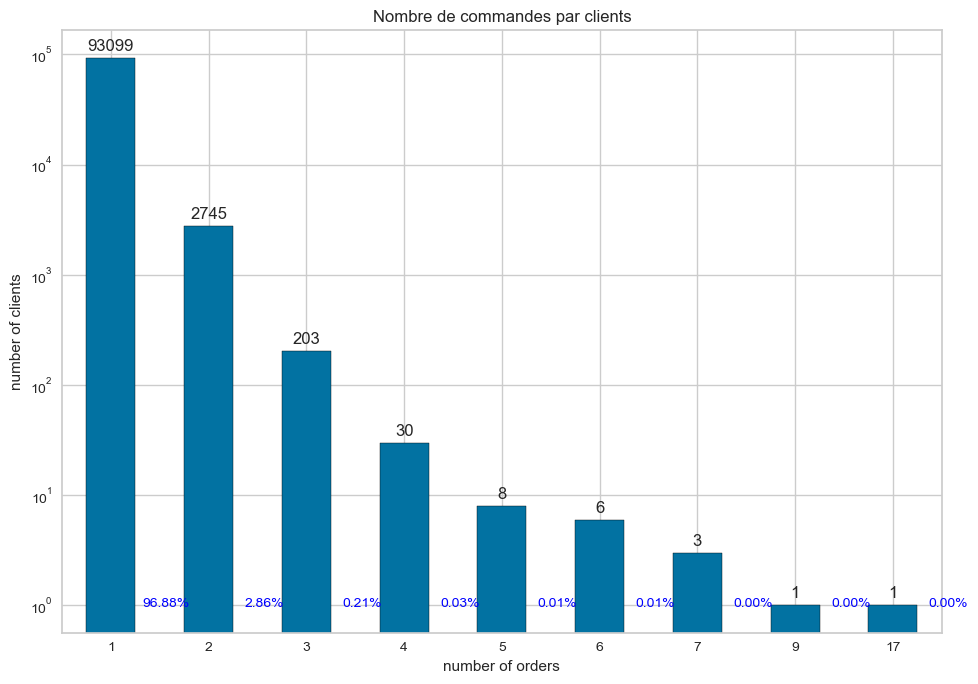

In [13]:
#plotting the number of orders by clients
fig = plt.figure(figsize=(10, 7))
x = data['total_orders'].value_counts().sort_index()
total = x.sum()
ax = x.plot(kind='bar', edgecolor='black')

for xaxis, yaxis in enumerate(x):
    ax.annotate(str(yaxis), xy=(xaxis, yaxis),  xytext=(0, 5), textcoords='offset points', ha='center')

for xaxis, yaxis in enumerate(x):
    percentage = (yaxis / total) * 100
    ax.annotate(f'{percentage:.2f}%', xy=(xaxis, 1),  xytext=(40, 5), textcoords='offset points', ha='center', va='top', fontsize=10, color='blue')

plt.yscale('log')
plt.xlabel('number of orders')
plt.xticks(rotation=0)
plt.ylabel('number of clients')
plt.title('Nombre de commandes par clients')
plt.tight_layout()

plt.show

piechart : 1 commande VS les autres

On constate qu'à peine plus que 3% des clients on fait plus qu'une seule commande

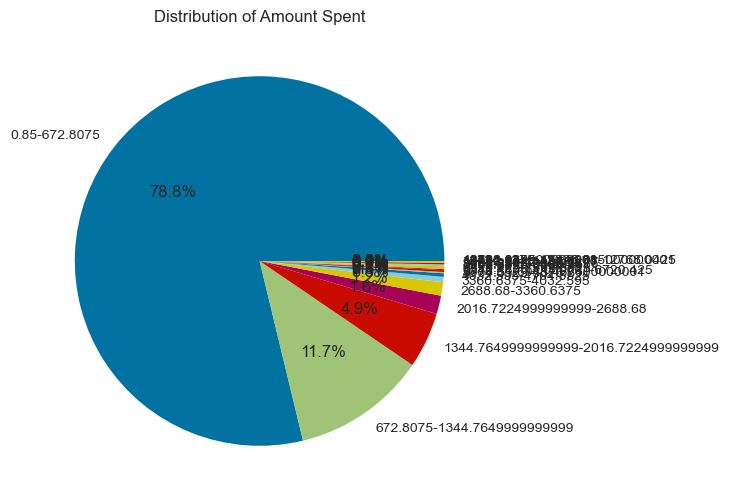

In [14]:
# Calculate the bin edges and counts
n, bins = np.histogram(data['total_price_items'], bins=20)

# Calculate the total amount spent in each bin
bin_totals = [data['total_price_items'][(data['total_price_items'] >= bins[i]) & (data['total_price_items'] < bins[i+1])].sum() for i in range(len(bins)-1)]

# Create labels for the pie chart
bin_labels = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)]

# Create the pie chart
plt.figure(figsize=(10, 6))
plt.pie(np.round(bin_totals), labels=bin_labels, autopct='%1.1f%%')
plt.title('Distribution of Amount Spent')
plt.show()

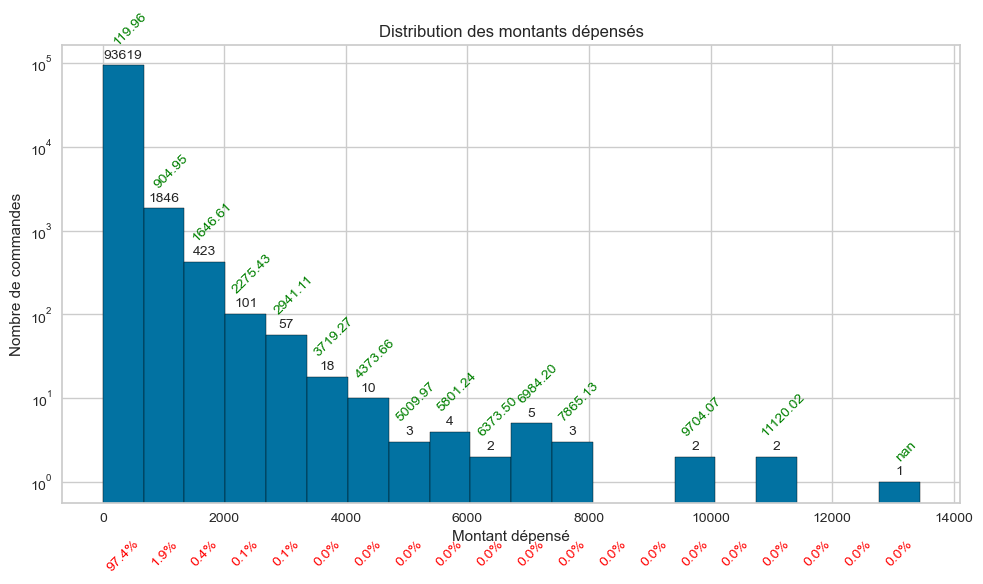

In [15]:
#Plotting the amount spent distribution
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(data['total_price_items'], bins=20, edgecolor='black')
# Calculate the bin centers
bin_centers = 0.5 * (bins[:-1] + bins[1:])

#Amount of clients in each bins
for count, bin_edge in zip(n, bins[:-1]):
    if count > 0:  #only for non-empty bins
        plt.annotate(f'{int(count)}', xy=(bin_edge + (bins[1] - bins[0])/2, count), xytext=(0, 5), textcoords='offset points', ha='center', fontsize=10)

#Mean amount spent in each bin
bin_indices = np.digitize(data['total_price_items'], bins)
bin_means = [data['total_price_items'][bin_indices == i].mean() for i in range(1, len(bins))]

#Annotate mean amount spent in each bin
for bin_mean, bin_center in zip(bin_means, bin_centers):
    plt.annotate(f'{bin_mean:.2f}', xy=(bin_center, n[np.where(bin_centers == bin_center)][0]), xytext=(5, 15), textcoords='offset points', ha='center', fontsize=10, color='green', rotation=45)

#Client percentage in each bins
total_clients = len(data)
for count, bin_center in zip(n, bin_centers):
    percentage_clients = (count / total_clients) * 100
    plt.annotate(f'{percentage_clients:.1f}%', xy=(bin_center, 1), xytext=(0, -40), textcoords='offset points', ha='center', va='top', fontsize=10, color='red', rotation=45)

plt.xlabel('Montant dépensé')
plt.ylabel('Nombre de commandes')
plt.yscale('log')
plt.title('Distribution des montants dépensés')
plt.tight_layout()
plt.show()

distribution plot : 'a quel point les montants sont éloigné de la moyenne'

En tant que ML => on s'assure que nos features tendent vers une loi normale

96.7% des clients ont un panier moyen de 120 Reals

### RFM : Récence Fréquence Montant

In [16]:
#Recence

#calculate the time since last seen
current_date = pd.to_datetime(datetime.now().date()) #maybe not use the current date but last date of DB update ('2021-10-01')
data['days_since_last_purchase'] = (current_date - data['last_purchase']).dt.days

# Insert the new column after the last_seen column
last_purchase_index = data.columns.get_loc('last_purchase')
data.insert(last_purchase_index + 1, 'days_since_last_purchase', data.pop('days_since_last_purchase'))

data.head()

,customer_unique_id,first_purchase,last_purchase,days_since_last_purchase,total_orders,total_spent,average_review_score,all_comments,total_price_items,total_freight_value,product_categories,seller_cities,order_statuses
0,8d50f5eadf50201ccdcedfb9e2ac8455,2017-05-15 23:30:03,2018-08-20 19:14:26,2116,17,927.63,NaN,NaN,729.62,172.42,"construcao_ferramentas_ferramentas, esporte_la...","campinas, curitiba, joinville, londrina, sao j...","delivered, shipped, unavailable"
1,3e43e6105506432c953e165fb2acf44c,2017-09-18 18:53:15,2018-02-27 18:36:39,2290,9,1963.58,NaN,NaN,1000.85,171.82,"cama_mesa_banho, casa_construcao, informatica_...","ibitinga, jaguariuna, porto alegre, rio de jan...",delivered
2,6469f99c1f9dfae7733b25662e7f1782,2017-09-19 01:02:44,2018-06-28 00:43:34,2169,7,973.09,NaN,NaN,664.20,94.63,cama_mesa_banho,"ibitinga, piracicaba, sao paulo",delivered
3,ca77025e7201e3b30c44b472ff346268,2017-10-09 12:34:39,2018-06-01 11:38:29,2196,7,2126.44,NaN,NaN,806.61,316.11,"cama_mesa_banho, cool_stuff, moveis_decoracao,...","ibitinga, pedreira, sao paulo",delivered
4,1b6c7548a2a1f9037c1fd3ddfed95f33,2017-11-13 16:44:41,2018-02-14 13:22:12,2303,7,1386.54,NaN,NaN,855.21,165.91,"beleza_saude, moveis_decoracao, papelaria, per...","formiga, itajai, mogi das cruzes, pedreira, sa...",delivered


Features RFM retenues : 
- last_purchase = Récence
- days_since_last_purchase = Fréquence
- total_price_items = Montant

In [17]:
#New df with only the 3 needed features
columns_RFM = ['last_purchase', 'days_since_last_purchase', 'total_price_items']
data_RFM = data[columns_RFM]

data_RFM

,last_purchase,days_since_last_purchase,total_price_items
0,2018-08-20 19:14:26,2116,729.62
1,2018-02-27 18:36:39,2290,1000.85
2,2018-06-28 00:43:34,2169,664.20
3,2018-06-01 11:38:29,2196,806.61
4,2018-02-14 13:22:12,2303,855.21
...,...,...,...
96091,2018-06-06 10:46:09,2191,223.00
96092,2017-12-17 23:31:33,2362,59.00
96093,2017-08-04 23:18:15,2497,143.80
96094,2018-08-12 20:27:59,2124,30.00


#### Moving on : standardscaling

In [18]:
#Can't standardscale the datetime column
data_RFM['last_purchase'] = data_RFM['last_purchase'].apply(lambda x: x.timestamp())

C:\Users\kanam\AppData\Local\Temp\ipykernel_11292\1263757375.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_RFM['last_purchase'] = data_RFM['last_purchase'].apply(lambda x: x.timestamp())


In [19]:
data_RFM

,last_purchase,days_since_last_purchase,total_price_items
0,1.534792e+09,2116,729.62
1,1.519757e+09,2290,1000.85
2,1.530147e+09,2169,664.20
3,1.527853e+09,2196,806.61
4,1.518615e+09,2303,855.21
...,...,...,...
96091,1.528282e+09,2191,223.00
96092,1.513553e+09,2362,59.00
96093,1.501889e+09,2497,143.80
96094,1.534106e+09,2124,30.00


In [20]:
scaler = StandardScaler()
scaler.fit_transform(data_RFM)

array([[ 1.50098038, -1.49989055,  2.34554623],
       [ 0.36663465, -0.36572729,  3.44029403],
       [ 1.15048497, -1.15442703,  2.08149579],
       ...,
       [-0.98136746,  0.9835359 , -0.0189605 ],
       [ 1.44916734, -1.44774511, -0.47828396],
       [ 1.37060981, -1.36952695,  0.04638613]])

In [21]:
kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(data_RFM)

C:\Users\kanam\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\kanam\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [22]:
kmeans.labels_
kmeans.cluster_centers_

array([[1.52809732e+09, 2.19332445e+03, 1.51055101e+02],
       [1.49595305e+09, 2.56536891e+03, 1.51909127e+02],
       [1.51360373e+09, 2.36107370e+03, 1.43814776e+02]])

k-means avec les 3 variables

Scores d'évaluation de nb de clusters ?

recherche théorique sur k-means

note : brut-test le code avant de le réécrire

In [23]:
kmeans = KMeans(n_clusters=2, random_state=42)
silhouette_score(data_RFM, kmeans.fit_predict(data_RFM))

#takes 177 seconds to run

0.5961990929997115

In [24]:
for k in range (2, 13):
    kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++')
    sscore = silhouette_score(data_RFM, kmeans.fit_predict(data_RFM))
    print(f'Silhouette score for {k} clusters is {sscore}')

Silhouette score for 2 clusters is 0.5961990929997115
Silhouette score for 3 clusters is 0.5775986466214887
Silhouette score for 4 clusters is 0.5508239950552791
Silhouette score for 5 clusters is 0.559780458114916
Silhouette score for 6 clusters is 0.5513136293791309
Silhouette score for 7 clusters is 0.5622120313222848
Silhouette score for 8 clusters is 0.5616591205542613
Silhouette score for 9 clusters is 0.5564266847322835
Silhouette score for 10 clusters is 0.5612783202715858
Silhouette score for 11 clusters is 0.5734230192921702
Silhouette score for 12 clusters is 0.5683788666029428


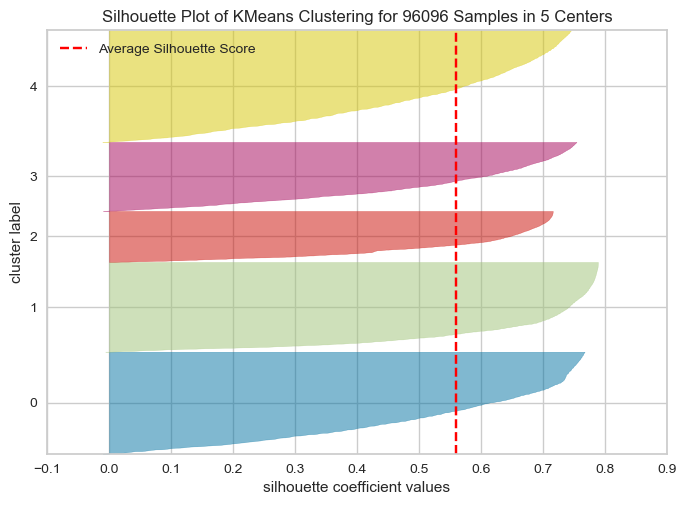

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 96096 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [25]:
#density visualizer Silhouette
model = KMeans(5, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(data_RFM)        # Fit the data to the visualizer
visualizer.show() 

silhouette is way longer than Elbow

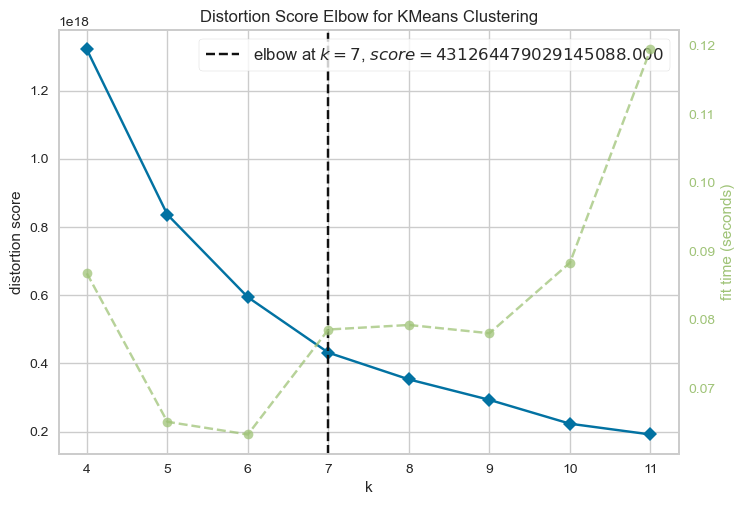

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [26]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,12))

visualizer.fit(data_RFM)        # Fit the data to the visualizer
visualizer.show()

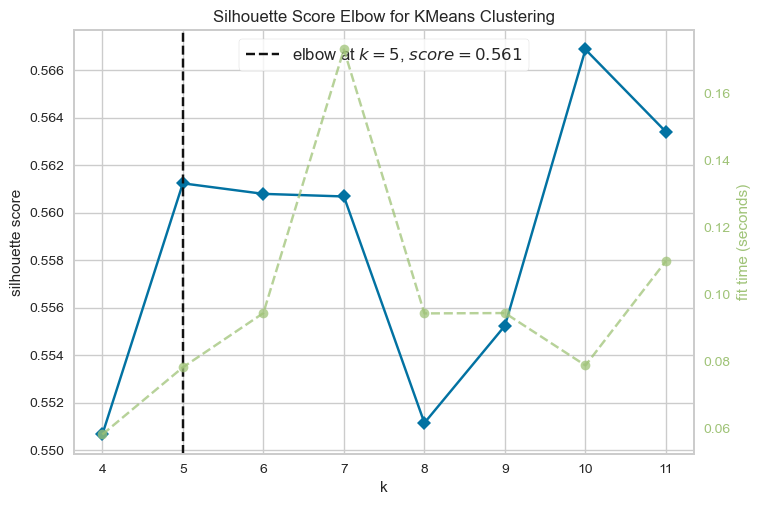

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [27]:
model = KMeans()
visualizer = KElbowVisualizer(model, metric='silhouette', k=(4,12))

visualizer.fit(data_RFM)        # Fit the data to the visualizer
visualizer.show()

distortion score + davis bouldin + score silhouette sur le meme graph \
pipeline = standardscaler + reentrainement kmeans final

In [29]:
# pipeline
best_k = 4

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=best_k, random_state=42, n_init=10))
])

# Fit the pipeline to the data
pipeline.fit(data_RFM)

cluster_labels = pipeline.predict(data_RFM)
print(cluster_labels)

[0 3 0 ... 1 0 0]


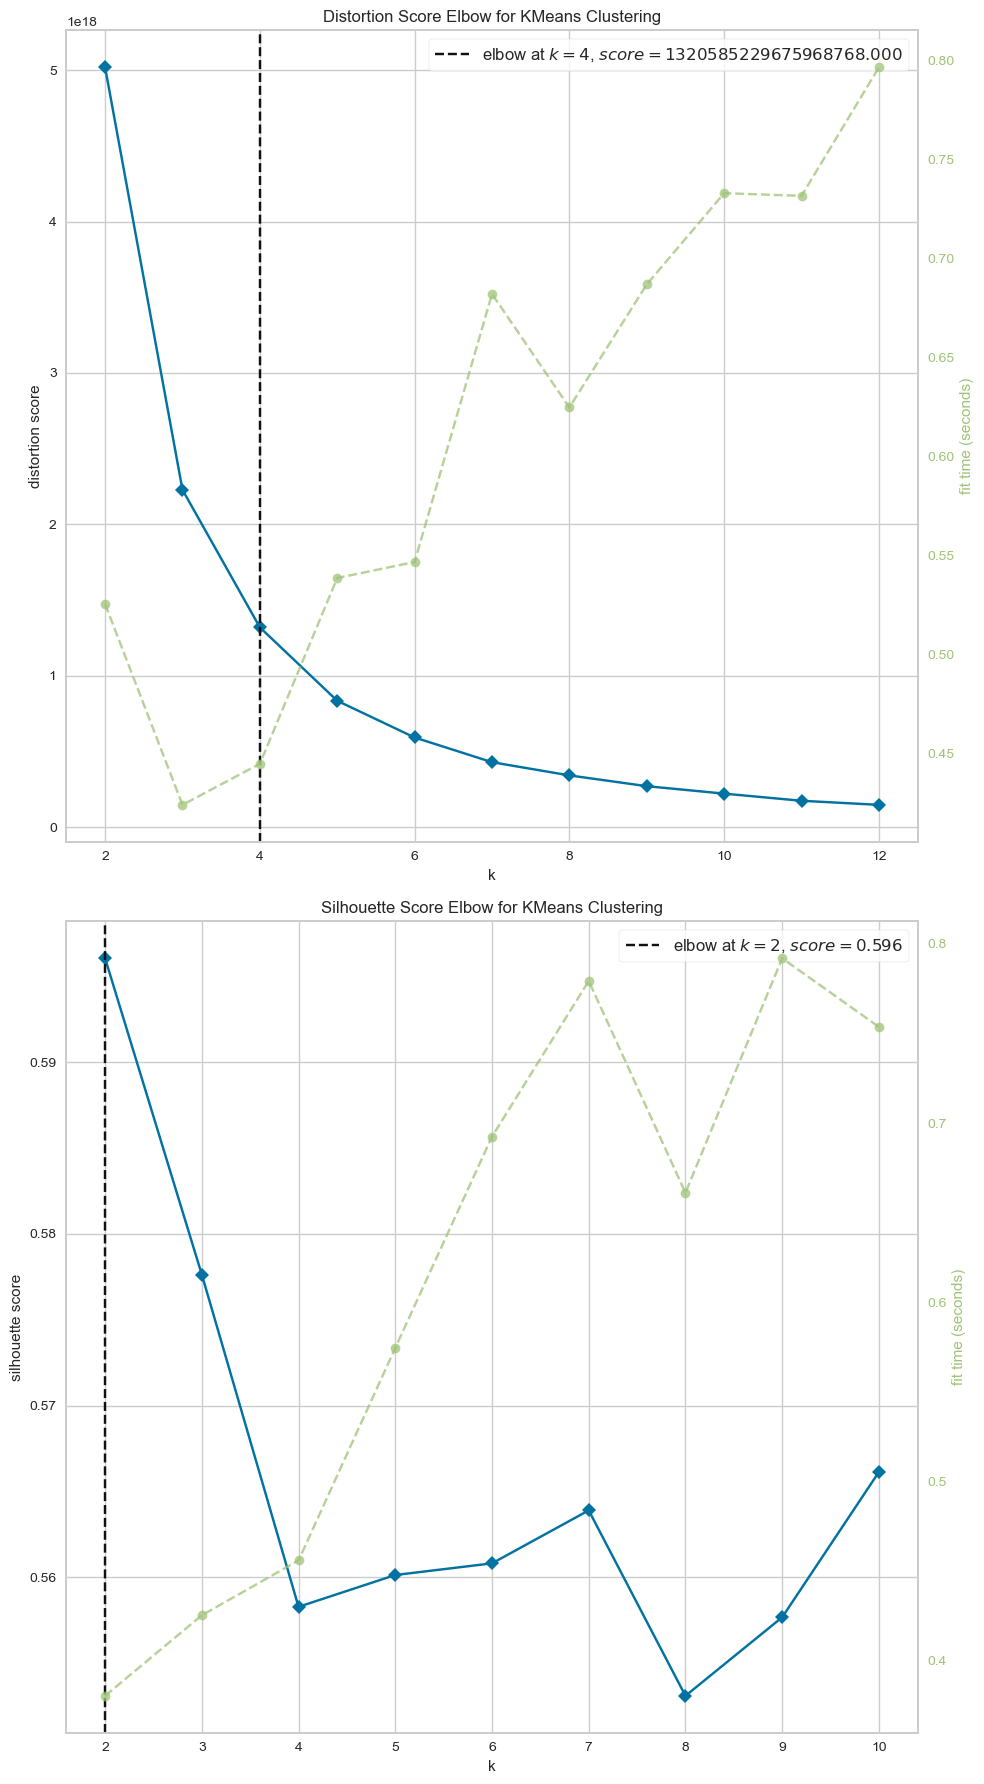

In [33]:
cluster_range = range(2, 13)

# Create subplots
fig, ax = plt.subplots(2, 1, figsize=(10, 18))

# Distortion Score (Elbow Method)
elbow_visualizer = KElbowVisualizer(KMeans(random_state=42, n_init=10), k=cluster_range, ax=ax[0])
elbow_visualizer.fit(data_RFM)
elbow_visualizer.finalize()

# Silhouette Score
km = KMeans(n_clusters=k, random_state=42, n_init=10)
visualizer = KElbowVisualizer(km, metric='silhouette', ax=ax[1])
visualizer.fit(data_RFM)
visualizer.finalize()

plt.tight_layout()
plt.show()

Optimal K confirmed between 4 and 2

Using the total number of clients is not necessarily relevant, due to the only one purchase made bringing very little information

Using only the multiple times buyer :
pros = better information
cons = 97% of data is unusable (only 3000 customers)

Not reasonnably feasable, but worth to mention to olist teams

Adding features : 

- total_orders => indicates if customers returns to olist, and how much so.
- I don't like the all_comments and review_score features, as they are very limited (120 and 279 non-null only)
- total_freight_value => is the client ready to spend with olist despite the distance and increased freigth tarification

Rework the SQL query to include more features ?

récupérer le label attribué avec .labels_
merge avec le dataframe
ensuite groupby cluster pour les analyses
analyse bivariés => corrélation (pearson)

boxplots : feature par cluster ET cluster par features

diagramme RADAR feature par cluster

Enrichir le jeu de données => total_orders / total_freight_value

A tester 
DBSCAN => répartition étrange des clusters => trop peu de données pertinentes
CAH => difficile à faire tourner => n'utiliser que 5% du dataset => Très puissant mais trop gourmand

+ review et correction de code

Contrat de maintenance :
On garde Kmeans 
On évalue avec RAND